This code trains a neural network using the dataset from the `dataset/label_dataset` file to determine various states based on the outputs of the app.


Numerische Spalten: ['places_top1_conf', 'places_top2_conf', 'places_top3_conf', 'places_top4_conf', 'places_top5_conf', 'ACT_confidence', 'YAMNET_conf_1', 'YAMNET_conf_2', 'YAMNET_conf_3', 'vehicle_audio_conf_1', 'vehicle_audio_conf_2', 'vehicle_audio_conf_3', 'vehicle_image_conf_1', 'vehicle_image_conf_2', 'vehicle_image_conf_3', 'speed_m_s', 'noise_dB']
Kategoriale Spalten: ['PLACES_top1', 'PLACES_top2', 'PLACES_top3', 'PLACES_top4', 'PLACES_top5', 'SCENE_TYPE', 'ACT', 'YAMNET_top1', 'YAMNET_top2', 'YAMNET_top3', 'VEHICLE_audio_1', 'VEHICLE_audio_2', 'VEHICLE_audio_3', 'VEHICLE_image_1', 'VEHICLE_image_2', 'VEHICLE_image_3']
Epoch 1/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.2655 - loss: 2.2511 - val_accuracy: 0.5940 - val_loss: 1.5933
Epoch 2/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6405 - loss: 1.0883 - val_accuracy: 0.7917 - val_loss: 0.8344
Epoch 3/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7781 - loss: 0.7226 - val_accuracy: 0.854

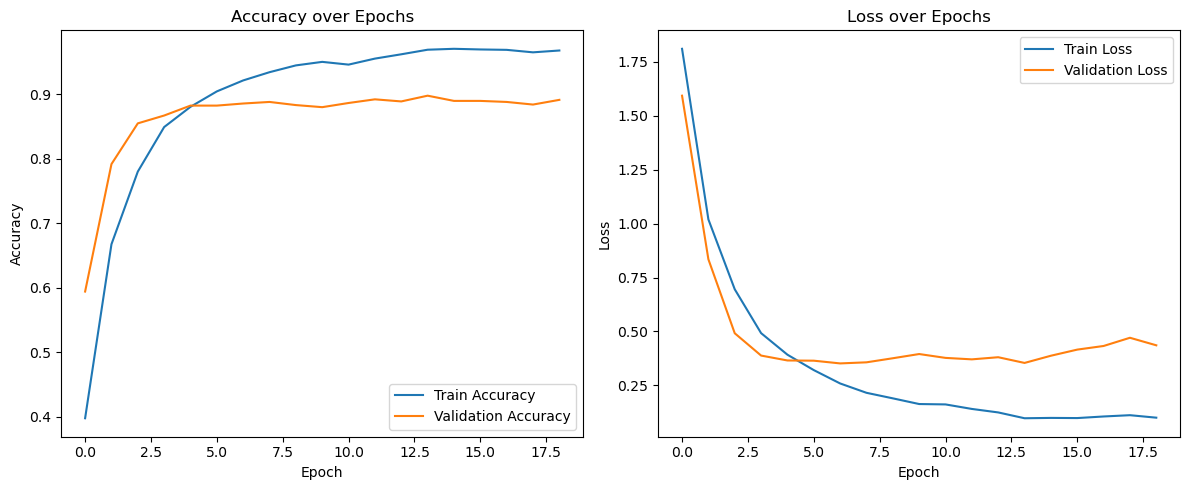

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Normalized Confusion Matrix:
[[0.82575758 0.         0.01515152 0.00757576 0.06818182 0.01515152
  0.01515152 0.         0.01515152 0.03787879 0.        ]
 [0.00819672 0.8852459  0.         0.10655738 0.         0.
  0.         0.         0.         0.         0.        ]
 [0.03921569 0.         0.74509804 0.09803922 0.06862745 0.
  0.00980392 0.00980392 0.         0.01960784 0.00980392]
 [0.         0.0292887  0.0041841  0.94142259 0.0083682  0.
  0.0041841  0.0041841  0.0083682  0.         0.        ]
 [0.05369128 0.         0.01342282 0.         0.82550336 0.00671141
  0.02013423 0.         0.02684564 0.03355705 0.02013423]
 [0.02666667 0.         0.04       0.02666667 0.02666667 0.88
  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.01145038 0.01145038 0.
  0.9351145  0.00381679 0.         0.         0.03816794]
 [0.05       0.         0.         0.         0.025      0.
  0.         0.875      0.0

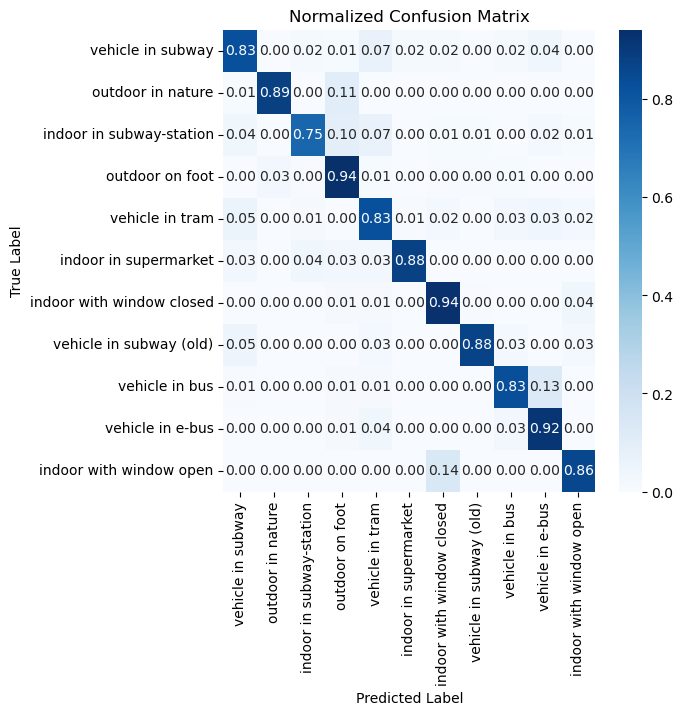

Classification Report:
                           precision    recall  f1-score   support

        vehicle in subway       0.86      0.83      0.84       132
        outdoor in nature       0.94      0.89      0.91       122
 indoor in subway-station       0.90      0.75      0.82       102
          outdoor on foot       0.87      0.94      0.91       239
          vehicle in tram       0.79      0.83      0.81       149
    indoor in supermarket       0.96      0.88      0.92        75
indoor with window closed       0.90      0.94      0.92       262
  vehicle in subway (old)       0.92      0.88      0.90        40
           vehicle in bus       0.90      0.83      0.86       138
         vehicle in e-bus       0.82      0.92      0.87       149
  indoor with window open       0.89      0.86      0.87       135

                 accuracy                           0.88      1543
                macro avg       0.89      0.87      0.87      1543
             weighted avg       0.88 

In [1]:
#!/usr/bin/env python3
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Pfad zur CSV-Datei mit den 5-Sekunden-Outputs der App (kommagetrennt)
CSV_PATH = r"C:\Users\lpera\label_dataset\merged_label_dataset.csv"

def load_and_split_data(csv_path):
    """
    Liest die CSV-Datei ein (mit Komma als Delimiter), entfernt die 'timestamp'-Spalte und
    teilt die Daten stratified in Trainings- und Testdaten auf (80/20).
    """
    # Lese die CSV-Datei mit Komma als Delimiter
    df = pd.read_csv(csv_path, delimiter=",", encoding="utf-8")
    
    # Säubere die Spaltennamen (entfernt etwaige Leerzeichen)
    df.columns = df.columns.str.strip()
    
    # Entferne die "timestamp"-Spalte, falls vorhanden
    if "timestamp" in df.columns:
        df = df.drop(columns=["timestamp"])
        
    # Konvertiere das Label in String und in Kleinbuchstaben
    df["status_gt"] = df["status_gt"].astype(str).str.lower()
    
    # Aufteilen in Trainings- und Testdaten (80% Training, 20% Test) mit stratified split
    train_df, test_df = train_test_split(
        df, test_size=0.2, random_state=42, stratify=df["status_gt"]
    )
    return train_df, test_df

def get_feature_columns(df):
    """
    Nutzt alle Spalten außer 'status_gt' als Features und unterscheidet numerische von 
    kategorialen Spalten.
    """
    feature_cols = [col for col in df.columns if col != "status_gt"]
    numeric_cols = []
    categorical_cols = []
    for col in feature_cols:
        if df[col].dtype == object:
            categorical_cols.append(col)
        else:
            numeric_cols.append(col)
    return numeric_cols, categorical_cols

def build_preprocessing_model(train_df, numeric_cols, categorical_cols):
    """
    Baut einen Preprocessing-Zweig:
      - Numerische Features werden mit tf.keras.layers.Normalization normalisiert.
      - Kategoriale Features werden mittels StringLookup und One-Hot-Encoding verarbeitet.
    Alle vorverarbeiteten Features werden konkateniert.
    """
    inputs = {}
    encoded_features = []
    
    # Numerische Features: Normalisierung
    for col in numeric_cols:
        inp = tf.keras.Input(shape=(1,), name=col)
        norm = tf.keras.layers.Normalization(name=f"{col}_norm")
        norm.adapt(train_df[[col]].values)
        encoded = norm(inp)
        inputs[col] = inp
        encoded_features.append(encoded)
    
    # Kategoriale Features: StringLookup und One-Hot-Encoding
    for col in categorical_cols:
        inp = tf.keras.Input(shape=(1,), name=col, dtype=tf.string)
        lookup = tf.keras.layers.StringLookup(output_mode='int', name=f"{col}_lookup")
        lookup.adapt(train_df[col].values)
        num_tokens = lookup.vocabulary_size()
        one_hot = tf.keras.layers.CategoryEncoding(num_tokens=num_tokens, output_mode='one_hot', name=f"{col}_onehot")
        encoded = one_hot(lookup(inp))
        inputs[col] = inp
        encoded_features.append(encoded)
    
    concatenated = tf.keras.layers.Concatenate()(encoded_features)
    return inputs, concatenated

def build_model(feature_vector):
    """
    Baut ein neuronales Netzwerk, das den Status klassifiziert.
    Es enthält Dense-Schichten, BatchNormalization und Dropout, 
    und endet in einer Ausgabeschicht, die 7 Klassen (oder mehr, je nach Mapping) abbildet.
    """
    x = tf.keras.layers.Dense(128, activation='relu')(feature_vector)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    # Passe hier die Anzahl der Ausgabeneuronen an dein Label-Mapping an.
    output = tf.keras.layers.Dense(11, activation='softmax')(x)
    return output

def df_to_dict(df, feature_cols):
    """
    Wandelt einen DataFrame in ein Dictionary um, das von Keras als Input genutzt werden kann.
    """
    return {col: df[col].values for col in feature_cols}

def main():
    # 1) Daten laden und aufteilen
    train_df, test_df = load_and_split_data(CSV_PATH)
    
    # 2) Ermitteln der Feature-Spalten (numerisch und kategorial)
    numeric_cols, categorical_cols = get_feature_columns(train_df)
    print("Numerische Spalten:", numeric_cols)
    print("Kategoriale Spalten:", categorical_cols)
    
    # 3) Preprocessing-Modell erstellen: Wandelt Rohdaten in einen Feature-Vektor um.
    inputs, concatenated = build_preprocessing_model(train_df, numeric_cols, categorical_cols)
    
    # 4) Modell bauen
    outputs = build_model(concatenated)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    # 5) Eingabedaten vorbereiten: Verwende alle Spalten außer "status_gt".
    feature_cols = numeric_cols + categorical_cols
    train_features = df_to_dict(train_df, feature_cols)
    test_features = df_to_dict(test_df, feature_cols)
    
    # 6) Label Mapping: Passe das Mapping an deine Klassen an.
    label_mapping = {
        "vehicle in subway": 0,
        "outdoor in nature": 1,
        "indoor in subway-station": 2,
        "outdoor on foot": 3,
        "vehicle in tram": 4,
        "indoor in supermarket": 5,
        "indoor with window closed": 6,
        "vehicle in subway (old)": 7,
        "vehicle in bus": 8,
        "vehicle in e-bus": 9,
        "indoor with window open": 10
    }
    train_labels = train_df["status_gt"].map(label_mapping)
    test_labels = test_df["status_gt"].map(label_mapping)
    
    # Überprüfe unmappte Labels
    if train_labels.isnull().any() or test_labels.isnull().any():
        raise ValueError("Es gibt Labels in 'status_gt', die nicht im Mapping enthalten sind.")
    
    train_labels = train_labels.values
    test_labels = test_labels.values
    
    # 7) Callbacks: EarlyStopping und ModelCheckpoint
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
    checkpoint = tf.keras.callbacks.ModelCheckpoint("best_model.keras", monitor='val_accuracy', save_best_only=True)
    
    # 8) Training
    history = model.fit(train_features, train_labels,
                        epochs=50,
                        validation_split=0.2,
                        batch_size=32,
                        callbacks=[early_stopping, checkpoint])
    
    # 9) Evaluation
    loss, accuracy = model.evaluate(test_features, test_labels)
    print("Test Accuracy:", accuracy)
    
    # 10) Plot Trainingsverlauf
    plt.figure(figsize=(12,5))
    
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # 11) Confusion Matrix und Classification Report (normalisiert)
    test_pred = model.predict(test_features)
    test_pred_labels = np.argmax(test_pred, axis=1)
    
    cm = confusion_matrix(test_labels, test_pred_labels)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized Confusion Matrix:")
    print(cm_normalized)
    
    plt.figure(figsize=(6,6))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=list(label_mapping.keys()),
                yticklabels=list(label_mapping.keys()))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Normalized Confusion Matrix')
    plt.show()
    
    report = classification_report(test_labels, test_pred_labels, target_names=list(label_mapping.keys()))
    print("Classification Report:")
    print(report)

        
    # 12) Modell speichern
    model.save("tf_nn_model.keras")

if __name__ == "__main__":
    main()
